# Dirichlet Process Mixture Models in Pyro


## What are Bayesian nonparametric models?
Bayesian nonparametric models are models where the number of parameters grow freely with the amount of data provided; thus, instead of training several models that vary in complexity and comparing them, one is able to design a model whose complexity grows as more data are observed. The prototypical example of Bayesian nonparametrics in practice is the *Dirichlet Process Mixture Model* (DPMM). A DPMM allows for a practitioner to build a mixture model when the number of distinct clusters in the geometric structure of their data is unknown – in other words, the number of clusters is allowed to grow as more data is observed. This feature makes the DPMM highly useful towards exploratory data analysis, where few facets of the data in question are known; this presentation aims to demonstrate this fact.

## The Dirichlet Process (Ferguson, 1973)
Dirichlet processes are a family of probability distributions over discrete probability distributions. Formally, the Dirichlet process (DP) is specified by some base probability distribution $G_0: \Omega \to \mathbb{R}$ and a positive, real, scaling parameter commonly denoted as $\alpha$. A sample $G$ from a Dirichlet process with parameters $G_0: \Omega \to \mathbb{R}$ and $\alpha$ is itself a distribution over $\Omega$. For any disjoint partition $\Omega_1, ..., \Omega_k$ of $\Omega$, and any sample $G \sim DP(G_0, \alpha)$, we have:

$$(G(\Omega_1), ..., G(\Omega_k)) \sim \text{Dir}(\alpha G_0(\Omega_1), ..., \alpha G_0(\Omega_k))$$

Essentially, this is taking a discrete partition of our sample space $\Omega$ and subsequently constructing a discrete distribution over it using the base distribution $G_0$. While quite abstract in formulation, the Dirichlet process is very useful as a prior in various graphical models. This fact becomes easier to see in the following scheme.

## The Chinese Restaurant Process (Aldous, 1985)

Imagine a restaurant with infinite tables (indexed by the positive integers) that accepts customers one at a time. The $n$th customer chooses their seat according to the following probabilities:

*   With probability $\frac{n_t}{\alpha + n - 1}$, sit at table $t$, where $n_t$ is the number of people at table $t$
*   With probability $\frac{\alpha}{\alpha + n - 1}$, sit at an empty table

If we associate to each table $t$ a draw from a base distribution $G_0$ over $\Omega$, and then associate unnormalized probability mass $n_t$ to that draw, the resulting distribution over $\Omega$ is equivalent to a draw from a Dirichlet process $DP(G_0, \alpha)$. 

Furthermore, we can easily extend this to define the generative process of a nonparametric mixture model: every table $t$ that has at least one customer seated is associated with a set of cluster parameters $\theta_t$, which were themselves drawn from some base distribution $G_0$. For each new observation, first assign that observation to a table according to the above probabilities; then, that observation is drawn from the distribution parameterized by the cluster parameters for that table. If the observation was assigned to a new table, draw a new set of cluster parameters from $G_0$, and then draw the observation from the distribution parameterized by those cluster parameters.

While this formulation of a Dirichlet process mixture model is intuitive, it is also very difficult to perform inference on in a probabilistic programming framework. This motivates an alternative formulation of DPMMs, which has empirically been shown to be more conducive to inference (e.g. Blei and Jordan, 2004).

## The Stick-Breaking Method (Sethuraman, 1994)

The generative process for the stick-breaking formulation of DPMMs proceeds as follows:

* Draw $\beta_i \sim \text{Beta}(1, \alpha)$ for $i \in \mathbb{N}$
* Draw $\theta_i \sim G_0$ for $i \in \mathbb{N}$
* Construct the mixture weights $\pi$ by taking $\pi_i(\beta_{1:\infty}) = \beta_i \prod_{j<i} (1-\beta_j)$

* For each observation $n \in \{1, ..., N\}$, draw $z_n \sim \pi(\beta_{1:\infty})$, and then draw $x_n \sim f(\theta_{z_n})$

Here, the infinite nature of the Dirichlet process mixture model can more easily be seen. Furthermore, all $\beta_i$ are independent, so it is far easier to perform inference in a probabilistic programming framework.

First, we import all the modules we're going to need:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.0')
pyro.set_rng_seed(0)



## **Inference**




### Synthetic Mixture of Gaussians

We begin by demonstrating the capabilities of Dirichlet process mixture models on a synthetic dataset generated by a mixture of four 2D Gaussians:

In [2]:
from xrdc import visualization as vis

Loading Data from: /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/inputs/
Data Loaded Succesfully
(177, 800)


In [181]:
ndim = 2
N = 1000
T = 3

# data = torch.dstack([MultivariateNormal(10 * Normal(0, 1).expand([ndim]).sample(), torch.eye(ndim)).sample([N]),
#                   MultivariateNormal(10 * Normal(0, 1).expand([ndim]).sample(), torch.eye(ndim)).sample([N]),
#                   MultivariateNormal(10 * Normal(0, 1).expand([ndim]).sample(), torch.eye(ndim)).sample([N])])

weights = Dirichlet(torch.ones(nphases) * .2).expand([N]).sample()

centers = MultivariateNormal(20 * Normal(0, 1).expand([ndim]).sample(), torch.eye(ndim)).sample([T])

mixture_centers = torch.matmul(weights, centers)

X = data = MultivariateNormal(mixture_centers, torch.eye(ndim) / 10).sample()

X = X / X.abs().mean()
# X = torch.einsum('...ij,...j->...i', data, weights)

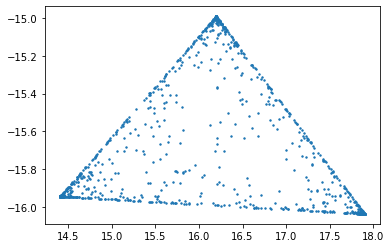

In [1105]:
plt.scatter(*np.array(mixture_centers.T), s = 2)

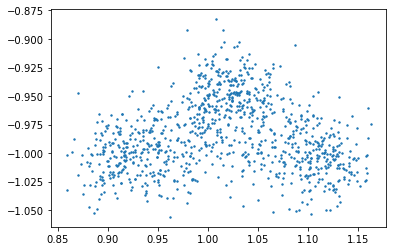

In [1116]:
plt.scatter(*np.array(X.T), s = 2)

In [1117]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [1118]:
T = 3
observation_sigma = .5
mu_scale = 10

In [1119]:
# def model(data):
#     weights = torch.ones(T) / T
#     #weights = pyro.sample('global_weights', Dirichlet(0.5 * torch.ones(T)))
    
# #     with pyro.plate("beta_plate", T-1):
# #         beta = pyro.sample("beta", Beta(1, alpha))

#     with pyro.plate("mu_plate", T):
#         mu = pyro.sample("mu", MultivariateNormal(mu_scale * torch.zeros(ndim), torch.eye(ndim)))

#     with pyro.plate("data", N):
# # #         z = pyro.sample("z", Categorical(mix_weights(beta)))
# # #         pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(ndim)), obs=data)
# #         phase_weights = pyro.sample("phase_weights", Dirichlet(mix_weights(beta)))
# #         ndsample = pyro.sample('ndsample', MultivariateNormal(mu, torch.eye(ndim) / 2).to_event(1))
# #         pyro.sample('obs', Normal(torch.einsum('...ji,...j->...i', ndsample, phase_weights),
# #                                    observation_sigma).to_event(1), obs = data)
        
#         phase_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))
#         #ndsample = pyro.sample('ndsample', MultivariateNormal(mu, torch.eye(ndim) / 2).to_event(1))
#         weighted_expectation = torch.einsum('...ji,...j->...i', mu, phase_weights)
#         pyro.sample('obs', Normal(weighted_expectation,
#                                    observation_sigma).to_event(1), obs = data)

def model(data):
    weights = torch.ones(T) / T
    #weights = pyro.sample('global_weights', Dirichlet(0.5 * torch.ones(T)))
    
#     with pyro.plate("beta_plate", T-1):
#         beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(mu_scale * torch.zeros(ndim), torch.eye(ndim)))

    with pyro.plate("data", N):
# #         z = pyro.sample("z", Categorical(mix_weights(beta)))
# #         pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(ndim)), obs=data)
#         phase_weights = pyro.sample("phase_weights", Dirichlet(mix_weights(beta)))
#         ndsample = pyro.sample('ndsample', MultivariateNormal(mu, torch.eye(ndim) / 2).to_event(1))
#         pyro.sample('obs', Normal(torch.einsum('...ji,...j->...i', ndsample, phase_weights),
#                                    observation_sigma).to_event(1), obs = data)
        
        phase_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))
        #ndsample = pyro.sample('ndsample', MultivariateNormal(mu, torch.eye(ndim) / 2).to_event(1))
        weighted_expectation = torch.einsum('...ji,...j->...i', mu, phase_weights)
        pyro.sample('obs', Normal(weighted_expectation,
                                   observation_sigma).to_event(1), obs = data)

In [710]:
topic_weights_posterior = pyro.param(
    "topic_weights_posterior",
    lambda: torch.ones(2),
    constraint=constraints.positive,
)
        
topic_words_posterior = pyro.param(
    "topic_words_posterior",
    lambda: torch.ones(2, args.num_words),
    constraint=constraints.greater_than(0.5),
)
with pyro.plate("topics", 2):
    pyro.sample("topic_weights", Gamma(topic_weights_posterior, 1.0))
    pyro.sample("topic_words", Dirichlet(topic_words_posterior))

In [734]:
from torch import nn

# We will use amortized inference of the local topic variables, achieved by a
# multi-layer perceptron. We'll wrap the guide in an nn.Module.
def make_predictor(layer_size):
    layer_sizes = (
        [args.num_words]
        + [int(s) for s in args.layer_sizes.split("-")]
        + [args.num_topics]
    )
    logging.info("Creating MLP with sizes {}".format(layer_sizes))
    layers = []
    for in_size, out_size in zip(layer_sizes, layer_sizes[1:]):
        layer = nn.Linear(in_size, out_size)
        layer.weight.data.normal_(0, 0.001)
        layer.bias.data.normal_(0, 0.001)
        layers.append(layer)
        layers.append(nn.Sigmoid())
    layers.append(nn.Softmax(dim=-1))
    return nn.Sequential(*layers)

In [1122]:
# def guide(data):
#     #kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
#     tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(ndim), 10 * torch.eye(ndim)).sample([T]))
#     #phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)
    
#     #phi = pyro.param('phi', lambda: 1/T * torch.ones(T), constraint=constraints.simplex)
#     phi = pyro.param('phi', lambda: alpha * Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

# #     cluster_weights_posterior = pyro.param(
# #         'cluster_weights_posterior',
# #         lambda: torch.ones(T) / T,
# #         contraint = constraints.positive,
# #     )

# #     with pyro.plate("beta_plate", T-1):
# #         q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

# #     with pyro.plate("global_weights_plate", T):
# #         q_weights = pyro.sample("global_weights", Delta(phi))

#     with pyro.plate("mu_plate", T):
#         q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(ndim)))

#     with pyro.plate("data", N):
#         #phase_weights = pyro.sample('phase_weights', Dirichlet(alpha * phi))
#         phase_weights = pyro.sample('phase_weights', Delta(phi).to_event(1))

def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(ndim), 5 * torch.eye(ndim)).sample([T]))
    #phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)
    
    #phi = pyro.param('phi', lambda: 1/T * torch.ones(T), constraint=constraints.simplex)
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

#     cluster_weights_posterior = pyro.param(
#         'cluster_weights_posterior',
#         lambda: torch.ones(T) / T,
#         contraint = constraints.positive,
#     )

#     with pyro.plate("beta_plate", T-1):
#         q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

#     with pyro.plate("global_weights_plate", T):
#         q_weights = pyro.sample("global_weights", Delta(phi))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(ndim)))

    with pyro.plate("data", N):
        phase_weights = pyro.sample('phase_weights', Dirichlet(alpha * phi))

In [1109]:
pyro.sample('phase_weights', Dirichlet(alpha * torch.ones(T) / T))

tensor([1.0000e+00, 6.8919e-09, 2.8135e-09])

In [1110]:
kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(ndim), 10 * torch.eye(ndim)).sample([T]))
#phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

phi = pyro.param('phi', lambda: 1/T * torch.ones(T), constraint=constraints.simplex)
phi2 = pyro.param('phi2', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

#     cluster_weights_posterior = pyro.param(
#         'cluster_weights_posterior',
#         lambda: torch.ones(T) / T,
#         contraint = constraints.positive,
#     )

#     with pyro.plate("beta_plate", T-1):
#         q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

with pyro.plate("global_weights_plate", T):
    q_weights = pyro.sample("global_weights", Delta(phi))

with pyro.plate("mu_plate", T):
    q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(ndim)))

with pyro.plate("data", N):
    phase_weights = pyro.sample('phase_weights', Dirichlet(alpha * phi2))

In [858]:
phi.shape

torch.Size([3])

In [859]:
q_weights.shape

torch.Size([3])

In [797]:
# kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
# tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(ndim), 10 * torch.eye(ndim)).sample([T]))
# phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

# with pyro.plate("beta_plate", T-1):
#     q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

# with pyro.plate("mu_plate", T):
#     q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(ndim)))

# with pyro.plate("data", N):
#     phase_weights = pyro.sample('phase_weights', Dirichlet(phi))

In [741]:
beta.shape, mu.shape, foo.shape

(torch.Size([2]), torch.Size([3, 2]), torch.Size([1000, 2]))

In [750]:
beta.shape, mu.shape, foo.shape

(torch.Size([2]), torch.Size([3, 2]), torch.Size([1000, 2]))

In [751]:
q_beta.shape, q_mu.shape, phase_weights.shape

(torch.Size([2]), torch.Size([3, 2]), torch.Size([1000, 3]))

In [739]:
phase_weights.shape

torch.Size([1000, 3])

100%|██████████| 500/500 [00:01<00:00, 334.48it/s]


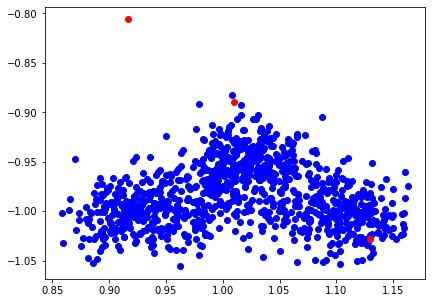

In [1123]:
n_iter = 500
T = 3
optim = Adam({"lr": 0.02})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(X)
        losses.append(loss)

def truncate(alpha, centers):#, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers#[weights > threshold]
    #true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers#, true_weights

alpha = .25
train(n_iter)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
# Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))
Bayes_Centers_01 = truncate(alpha, pyro.param("tau").detach())

# alpha = 1.5
# train(1000)

# # We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
# Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")


In [1006]:
data.mean(axis = 0)

tensor([[  0.5243,  -9.5567, -15.7553],
        [-18.0407,  11.8694,   6.0076]])

In [918]:
Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1]

(tensor([-8.5926, -8.4093, -8.4686]), tensor([0.0025, 0.1109, 0.1479]))

In [809]:
pyro.param('phi')

tensor([0.2742, 0.3301, 0.3957], grad_fn=<DivBackward0>)

In [793]:
nn

<module 'torch.nn' from '/home/ollie/anaconda3/lib/python3.8/site-packages/torch/nn/__init__.py'>

In [784]:
%pdb

Automatic pdb calling has been turned ON


ValueError: maxlags must be None or strictly positive < 500

> /home/ollie/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py(2126)xcorr()
   2124 
   2125         if maxlags >= Nx or maxlags < 1:
-> 2126             raise ValueError('maxlags must be None or strictly '
   2127                              'positive < %d' % Nx)
   2128 

ipdb> c


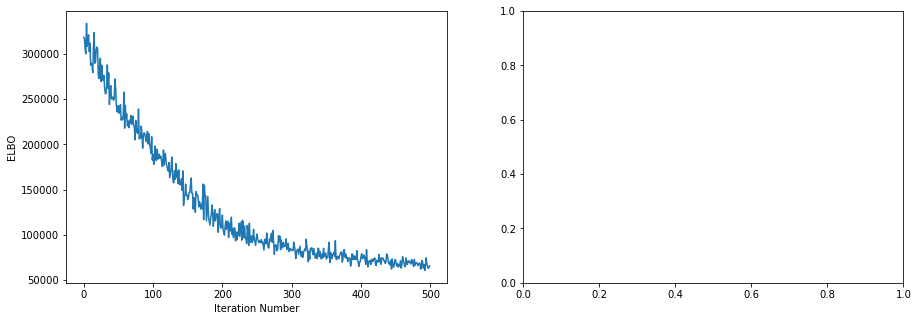

In [961]:
elbo_plot = plt.figure(figsize=(15, 5))

elbo_ax = elbo_plot.add_subplot(1, 2, 1)
# elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI on Sunspot Data")
elbo_ax.set_ylabel("ELBO")
elbo_ax.set_xlabel("Iteration Number")
elbo_ax.plot(np.arange(n_iter), losses)
#elbo_ax.semilogy()

autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
autocorr_ax.acorr(np.asarray(losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=',')
autocorr_ax.set_xlim(0, 500)
autocorr_ax.axhline(0, ls="--", c="k", lw=1)
# autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI on Sunspot Data")
autocorr_ax.set_xlabel("Lag")
autocorr_ax.set_ylabel("Autocorrelation")
elbo_plot.tight_layout()
plt.show()

In [628]:
# pyro.deterministic('obs', torch.einsum('...ji,...j->...i', ndsample, z), obs=data)

In [ ]:
from torch.distributions.transforms import *

In [745]:
alpha = 1
with pyro.plate("beta_plate", T-1):
    beta = pyro.sample("beta", Beta(1, alpha))

with pyro.plate("mu_plate", T):
    mu = pyro.sample("mu", MultivariateNormal(torch.zeros(ndim), 10 * torch.eye(ndim)))

In [746]:
# with pyro.plate("data", N):
# #         z = pyro.sample("z", Categorical(mix_weights(beta)))
# #         pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(ndim)), obs=data)
#     weights = mix_weights(beta)

#     z = pyro.sample("z", Dirichlet(mix_weights(beta)))
#     ndsample = pyro.sample('ndsample', MultivariateNormal(mu, torch.eye(ndim) / 2).to_event(1))
#     foo = pyro.sample('obs', Normal(torch.einsum('...ji,...j->...i', ndsample, z),
#                                    observation_sigma).to_event(1))

In [748]:
with pyro.plate("data", N):
#         z = pyro.sample("z", Categorical(mix_weights(beta)))
#         pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(ndim)), obs=data)
        phase_weights = pyro.sample("phase_weights", Dirichlet(mix_weights(beta)))
        #ndsample = pyro.sample('ndsample', MultivariateNormal(mu, torch.eye(ndim) / 2).to_event(1))
        weighted_expectation = torch.einsum('...ji,...j->...i', mu, phase_weights)
        foo = pyro.sample('foo', Normal(weighted_expectation,
                                   observation_sigma).to_event(1))

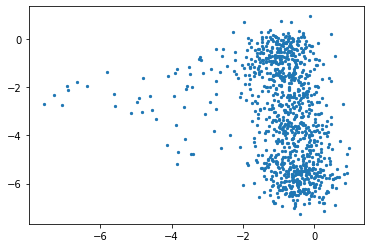

In [730]:
#ndsample = pyro.sample('ndsample', MultivariateNormal(mu, torch.eye(ndim)).to_event(1))
#foo = torch.einsum('...ji,...j->...i', ndsample, z)
plt.scatter(*np.array(foo.T), s = 5)

In [654]:
model(data).shape

torch.Size([1000, 2])

In [650]:
plt.scatter(*np.array(foo.T), s = 5)

TypeError: scatter() got multiple values for argument 's'

In [ ]:
# with pyro.plate("data", N):
# #         z = pyro.sample("z", Categorical(mix_weights(beta)))
# #         pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(ndim)), obs=data)
#     weights = mix_weights(beta)

#     z = pyro.sample("z", Dirichlet(mix_weights(beta)))[..., None]
#     #z_dist = Dirichlet(mix_weights(beta))
#     spatial_dist = MultivariateNormal(mu, torch.eye(ndim) / 2).to_event(1)
    
#     #ndsample = pyro.sample('ndsample', MultivariateNormal(mu, torch.eye(ndim) / 2).to_event(1))
#     #foo = pyro.deterministic('obs', torch.einsum('...ji,...j->...i', ndsample, z))
#     foo = pyro.sample('foo', TransformedDistribution(
#         spatial_dist, AffineTransform(0, z, event_dim = 1)))

In [749]:
foo.shape

torch.Size([1000, 2])

In [232]:
with pyro.plate("data2", N):
    zz = pyro.sample("zz", mix_weights(beta))

TypeError: 'Tensor' object is not callable

In [220]:
torch.einsum('...ji,...j->...i', MultivariateNormal(mu, torch.eye(ndim)), z)

TypeError: expected Tensor as element 0 in argument 1, but got MultivariateNormal

In [219]:
data.shape

torch.Size([1000, 2, 3])

In [218]:
MultivariateNormal(mu, torch.eye(ndim)).sample().shape

torch.Size([10, 2])

In [204]:
mu.shape

torch.Size([10, 2])

In [202]:
z

tensor([1, 1, 0, 1, 3, 1, 0, 3, 1, 1, 0, 0, 0, 0, 3, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 3, 3, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 2, 3, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 3, 1, 0, 0, 0, 3, 2, 3, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0, 1, 1, 1,
        0, 0, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3,
        0, 0, 0, 1, 2, 1, 3, 1, 0, 0, 0, 3, 1, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 0, 3, 1, 0, 0, 1, 0, 2, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 4, 0, 0, 1, 1, 3, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 4, 3, 0, 0, 0, 1, 3, 0, 1, 0, 0, 3, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0,
        0, 1, 0, 1, 1, 3, 0, 1, 0, 1, 1,

In [200]:
mix_weights(beta)

tensor([5.4550e-01, 3.2146e-01, 2.9718e-02, 9.6878e-02, 2.6278e-03, 1.4487e-03,
        1.6422e-03, 6.7143e-04, 5.2240e-05, 6.4042e-06])

In [190]:
z = pyro.sample("z", mix_weights(beta))

AssertionError: Padding length too large

In [187]:
mu

tensor([-0.8807, -1.3585])

In [185]:
z = 0
MultivariateNormal(mu[z], torch.eye(ndim))

ValueError: loc must be at least one-dimensional.

In [ ]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

In [89]:
weights.shape

torch.Size([1000, 3])

In [62]:
data.shape

torch.Size([150, 2])

In [68]:
Dirichlet(torch.ones(2)).sample()

tensor([0.0779, 0.9221])

In [ ]:
with pyro.plate("beta_plate", T-1):
    beta = pyro.sample("beta", Beta(1, alpha))

with pyro.plate("mu_plate", T):
    mu = pyro.sample("mu", MultivariateNormal(torch.zeros(ndim), 5 * torch.eye(ndim)))
    #print(mu.shape)

with pyro.plate("data", N):
    z = pyro.sample("z", Categorical(mix_weights(beta)))
    pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(ndim)), obs=data)

In [45]:
ndim = 2
nphases = 3
N = 1000

In [59]:
locs, scales = np.random.normal(0, 1, size = (nphases, ndim)),np.abs(np.random.normal(0, 1, size = (nphases, ndim)) / 5)
weights = np.random.dirichlet([1] * nphases, N)

In [52]:
weights.shape

(1000, 3)

In [56]:
samples = np.vstack([np.random.normal(loc, scale, size = N) for loc, scale in zip(locs, scales)]).T

In [58]:
samples.shape

(1000, 3)

In [49]:
X

(1000, 2)

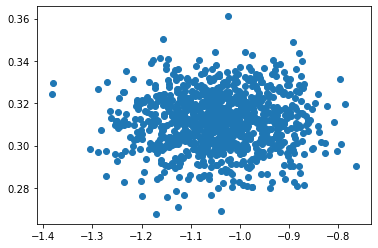

In [41]:
plt.scatter(*(X[:, :2].T));

In [19]:
data.shape

torch.Size([60000, 25])

In [14]:
data.reshape(25, -1)

torch.Size([25, 60000])

GMM

In [864]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)

K = T  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

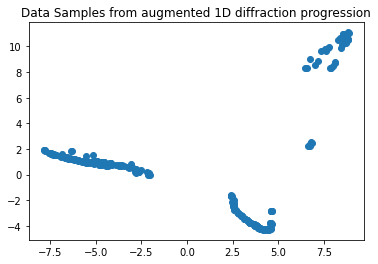

In [262]:
#data = torch.from_numpy(np.load('data/activations_n1_simple.npy').T)

data = torch.from_numpy(np.load('data/augmented.npy')).reshape(-1, 25)

ndim = 3
k = 300
_, _data = vis.do_pca(data, ndim)
data = _data[:30000][:k]
data_test = _data[30000:][:k]

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from augmented 1D diffraction progression")
plt.show()
N = data.shape[0]

data = torch.from_numpy(data).to(torch.float)
data_test = torch.from_numpy(data_test).to(torch.float)

In this example, the cluster parameters $\theta_i$ are two dimensional vectors describing the means of a multivariate Gaussian with identity covariance. Therefore, the Dirichlet process base distribution $G_0$ is also a multivariate Gaussian (i.e. the conjugate prior), although this choice is not as computationally useful, since we are not performing coordinate-ascent variational inference but rather black-box variational inference using Pyro. 

First, let's define the "stick-breaking" function that generates our weights, given our samples of $\beta$:

In [255]:
data.device

device(type='cpu')

In [256]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

Next, let's define our model. It may be helpful to refer the definition of the stick-breaking model presented in the first part of this tutorial. 

Note that all $\beta_i$ samples are conditionally independent, so we model them using a `pyro.plate` of size `T-1`; we do the same for all samples of our cluster parameters $\mu_i$. We then construct a Categorical distribution whose parameters are the mixture weights using our sampled $\beta$ values (line 9) below, and sample the cluster assignment $z_n$ for each data point from that Categorical. Finally, we sample our observations from a multivariate Gaussian distribution whose mean is exactly the cluster parameter corresponding to the assignment $z_n$ we drew for the point $x_n$. This can be seen in the Pyro code below:

In [257]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(ndim), 5 * torch.eye(ndim)))
        #print(mu.shape)

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(ndim)), obs=data)

Now, it's time to define our guide and perform inference. 

The variational family $q(\beta, \theta, z)$ that we are optimizing over during variational inference is given by:

$$q(\beta, \theta, z) = \prod_{t=1}^{T-1} q_t(\beta_t) \prod_{t=1}^T q_t(\theta_t) \prod_{n=1}^N q_n(z_n)$$ 

Note that since we are unable to computationally model the infinite clusters posited by the model, we truncate our variational family at $T$ clusters. This does not affect our model; rather, it is a simplification made in the *inference* stage to allow tractability. 

The guide is constructed exactly according to the definition of our variational family $q(\beta, \theta, z)$ above. We have $T-1$ conditionally independent Beta distributions for each $\beta$ sampled in our model, $T$ conditionally independent multivariate Gaussians for each cluster parameter $\mu_i$, and $N$ conditionally independent Categorical distributions for each cluster assignment $z_n$.

Our variational parameters (`pyro.param`) are therefore the $T-1$ many positive scalars that parameterize the second parameter of our variational Beta distributions (the first shape parameter is fixed at $1$, as in the model definition), the $T$ many two-dimensional vectors that parameterize our variational multivariate Gaussian distributions (we do not parameterize the covariance matrices of the Gaussians, though this should be done when analyzing a real-world dataset for more flexibility), and the $N$ many $T$-dimensional vectors that parameterize our variational Categorical distributions:

In [258]:
# def guide(data):
#     #options = dict()
#     options = dict(dtype=data.dtype, device=data.device)
#     d = 2

#     kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
#     tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
#     # Vector of variances for each of the d variables
    
#     # TODO sample for each component?
#     #theta = pyro.param("theta", HalfCauchy(torch.ones(d, **options)).sample(), constraint = constraints.positive)
#     theta = pyro.param("theta", HalfCauchy(torch.ones(d, **options)).sample([T]), constraint = constraints.positive)
    
    
#     #theta = pyro.sample("theta", HalfCauchy(torch.ones(d, **options)))
#     #theta = pyro.param("theta", HalfCauchy(torch.ones(d, **options)).sample())
#     #theta = pyro.sample("theta", HalfCauchy(torch.ones(d, **options)), [T])
#     phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

#     concentration = torch.ones(
#             (), **options
#         )

#     # Implies a uniform distribution over correlation matrices
#     L_omega = pyro.sample("L_omega", LKJCholesky(d, concentration), [T])

#     # Lower cholesky factor of the covariance matrix
#     #L_Omega = torch.matmul(torch.diag(theta.sqrt()), L_omega)
#     diags = torch.einsum('kj,ij->kij', theta.sqrt(), torch.eye(theta.shape[-1]))
#     L_Omega = torch.einsum('...ij,...jk->...ik', diags, L_omega)

#     with pyro.plate("beta_plate", T-1):
#         q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

#     with pyro.plate("mu_plate", T):
#         print(tau.shape)
#         print(L_Omega.shape)
#         q_mu = pyro.sample("mu", MultivariateNormal(tau, scale_tril=L_Omega))
#         #print(q_mu.shape)

#     with pyro.plate("data", N):
#         z = pyro.sample("z", Categorical(phi))

In [259]:
def guide(data):
    #options = dict()
    options = dict(dtype=data.dtype, device=data.device)
    d = ndim

    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(ndim), 3 * torch.eye(ndim)).sample([T]))
    # Vector of variances for each of the d variables
    # TODO sample for each component?
    theta = pyro.param("theta", HalfCauchy(torch.ones(d, **options)).sample(), constraint = constraints.positive)
    #theta = pyro.sample("theta", HalfCauchy(torch.ones(d, **options)))
    #theta = pyro.param("theta", HalfCauchy(torch.ones(d, **options)).sample())
    #theta = pyro.sample("theta", HalfCauchy(torch.ones(d, **options)), [T])
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    concentration = torch.ones(
            (), **options
        )

    # Implies a uniform distribution over correlation matrices
    L_omega = pyro.sample("L_omega", LKJCholesky(d, concentration))
    # Lower cholesky factor of the covariance matrix
    L_Omega = torch.matmul(torch.diag(theta.sqrt()), L_omega)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, scale_tril=L_Omega))
        #print(q_mu.shape)

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

When performing inference, we set our 'guess' for the maximum number of clusters in the dataset to $T = 6$. We define the optimization algorithm (`pyro.optim.Adam`) along with the Pyro SVI object and train the model for 1000 iterations. 

After performing inference, we construct the Bayes estimators of the means (the expected values of each factor in our variational approximation) and plot them in red on top of the original dataset.  Note that we also have we removed any clusters that have less than a certain weight assigned to them according to our learned variational distributions, and then re-normalize the weights so that they sum to one:

In [163]:
# theta = pyro.sample("theta", HalfCauchy(torch.ones(d, **options)))
# torch.diag(theta.sqrt())

# theta = pyro.param("foobar", HalfCauchy(torch.ones(d, **options)).sample())
# torch.diag(theta.sqrt())

# theta = pyro.param("zzz", lambda: HalfCauchy(torch.ones(d, **options)).sample())
# torch.diag(theta.sqrt())

  0%|          | 0/3000 [00:00<?, ?it/s]/home/ollie/anaconda3/lib/python3.8/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'L_omega'}
  warnings.warn(
100%|██████████| 3000/3000 [00:29<00:00, 101.60it/s]


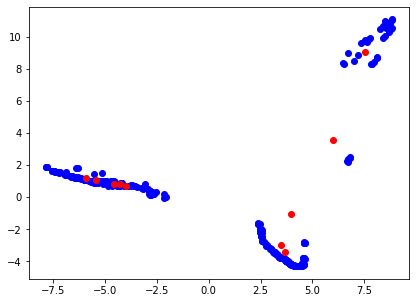

In [263]:
n_iter = 3000
T = 10
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 1
train(n_iter)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

# alpha = 1.5
# train(1000)

# # We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
# Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

# plt.subplot(1, 2, 2)
# plt.scatter(data[:, 0], data[:, 1], color="blue")
# plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
# plt.tight_layout()
# plt.show()

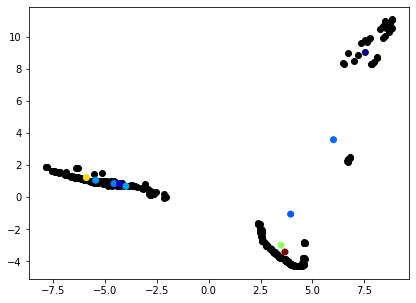

In [278]:
# # We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
# Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="k")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], c = np.array(Bayes_Weights_01), cmap = 'jet')

# plt.subplot(1, 2, 2)
# plt.scatter(data[:, 0], data[:, 1], color="blue")
# plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
# plt.tight_layout()
# plt.show()

In [188]:
a = np.ones((10, 2, 2)) * np.arange(10)[:, None, None]

In [217]:
b = np.ones((10 ,2)) * np.arange(10)[:, None] * np.array([1, 2])
b


array([[ 0.,  0.],
       [ 1.,  2.],
       [ 2.,  4.],
       [ 3.,  6.],
       [ 4.,  8.],
       [ 5., 10.],
       [ 6., 12.],
       [ 7., 14.],
       [ 8., 16.],
       [ 9., 18.]])

In [211]:
c = np.array([1, 2])
c

array([1, 2])

In [227]:
bb = np.einsum('kj,ij->kij', b, np.eye(b.shape[-1]))

In [230]:
np.einsum('...ij,...jk->...ik', bb, bb)

array([[[  0.,   0.],
        [  0.,   0.]],

       [[  1.,   0.],
        [  0.,   4.]],

       [[  4.,   0.],
        [  0.,  16.]],

       [[  9.,   0.],
        [  0.,  36.]],

       [[ 16.,   0.],
        [  0.,  64.]],

       [[ 25.,   0.],
        [  0., 100.]],

       [[ 36.,   0.],
        [  0., 144.]],

       [[ 49.,   0.],
        [  0., 196.]],

       [[ 64.,   0.],
        [  0., 256.]],

       [[ 81.,   0.],
        [  0., 324.]]])

In [159]:
%pdb

Automatic pdb calling has been turned ON


In [109]:
options = dict(dtype=data.dtype, device=data.device)
d = 2
concentration = torch.ones(
        (), **options
    )

theta = pyro.param("theta", HalfCauchy(torch.ones(d, **options)).sample(), constraint = constraints.positive)
# Implies a uniform distribution over correlation matrices
L_omega = pyro.sample("L_omega", LKJCholesky(d, concentration))
# Lower cholesky factor of the covariance matrix
L_Omega = torch.matmul(torch.diag(theta.sqrt()), L_omega)

In [267]:
N = data.shape[0]
N_test = data_test.shape[0]

alphas = [.01, .02, .03, 0.05, 0.1, .3, 1., 1.25, 1.5, 2, 3]
log_predictives = []

for val in alphas:
    alpha = val
    T = 6
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    train(500)
    
    S = ndim * 50 # number of Monte Carlo samples to use in posterior predictive computations

    # Using pyro's built in posterior predictive class:
    posterior = Predictive(guide, num_samples=S, return_sites=["beta", "mu"])(data_test)
    post_pred_weights = mix_weights(posterior["beta"])
    post_pred_clusters = posterior["mu"]
    
    # TODO use actual L_Omega. Need to actually sample here
    log_prob = (post_pred_weights.reshape(-1).log()[:S] +\
                MultivariateNormal(post_pred_clusters.reshape(-1, ndim)[:S], scale_tril=L_Omega)\
        .log_prob(data_test).detach()).logsumexp(-1)
    mean_log_prob = log_prob - np.log(S)
    log_predictives.append(mean_log_prob)

#     # log_prob shape = N_test x S
# #     log_prob = (post_pred_weights.log() + Poisson(post_pred_clusters).log_prob(data.reshape(-1, 1, 1))).logsumexp(-1)
# #     mean_log_prob = log_prob.logsumexp(-1) - np.log(S)
# #     log_posterior_predictive = mean_log_prob.sum(-1)
#     log_prob = 
#     log_predictives.append(log_posterior_predictive)

plt.figure(figsize=(10, 5))
plt.plot(alphas, log_predictives)
plt.title("Value of the Log Predictive at Varying Alpha")
plt.show()

100%|██████████| 500/500 [00:04<00:00, 102.54it/s]


ValueError: Value is not broadcastable with batch_shape+event_shape: torch.Size([300, 3]) vs torch.Size([150, 3]).

> /home/ollie/anaconda3/lib/python3.8/site-packages/torch/distributions/distribution.py(276)_validate_sample()
    274         for i, j in zip(reversed(actual_shape), reversed(expected_shape)):
    275             if i != 1 and j != 1 and i != j:
--> 276                 raise ValueError('Value is not broadcastable with batch_shape+event_shape: {} vs {}.'.
    277                                  format(actual_shape, expected_shape))
    278         try:

ipdb> c


In [56]:
%pdb

Automatic pdb calling has been turned ON


In [268]:
Bayes_Weights_01.sort()

torch.return_types.sort(
values=tensor([0.0474, 0.0570, 0.0794, 0.0815, 0.0851, 0.0884, 0.0908, 0.1257, 0.1482,
        0.1965]),
indices=tensor([8, 5, 0, 2, 3, 6, 1, 7, 9, 4]))

The plots above demonstrate the effects of the scaling hyperparameter $\alpha$. A greater $\alpha$ yields a more heavy-tailed distribution of the weights, whereas smaller $\alpha$ will place more mass on fewer clusters. In particular, the middle cluster looks like it could be generated a single Gaussian (although in fact it was generated by two distinct Gaussians), and thus the setting of $\alpha$ allows the practitioner to further encode their prior beliefs about how many clusters the data contains.

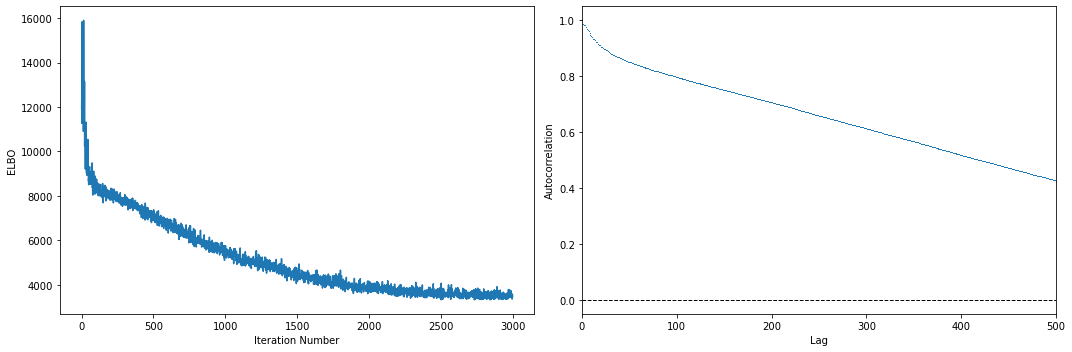

In [264]:
elbo_plot = plt.figure(figsize=(15, 5))

elbo_ax = elbo_plot.add_subplot(1, 2, 1)
# elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI on Sunspot Data")
elbo_ax.set_ylabel("ELBO")
elbo_ax.set_xlabel("Iteration Number")
elbo_ax.plot(np.arange(n_iter), losses)
#elbo_ax.semilogy()

autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
autocorr_ax.acorr(np.asarray(losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=',')
autocorr_ax.set_xlim(0, 500)
autocorr_ax.axhline(0, ls="--", c="k", lw=1)
# autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI on Sunspot Data")
autocorr_ax.set_xlabel("Lag")
autocorr_ax.set_ylabel("Autocorrelation")
elbo_plot.tight_layout()
plt.show()

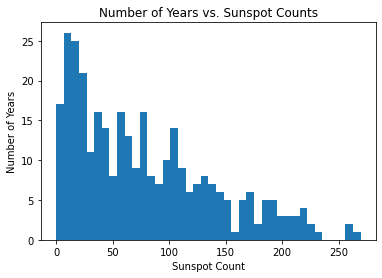

In [7]:
df = pd.read_csv('http://www.sidc.be/silso/DATA/SN_y_tot_V2.0.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32).round()
N = data.shape[0]

plt.hist(df['sunspot.year'].values, bins=40)
plt.title("Number of Years vs. Sunspot Counts")
plt.xlabel("Sunspot Count")
plt.ylabel("Number of Years")
plt.show()

100%|██████████| 1500/1500 [00:04<00:00, 351.82it/s]


tensor([[4.4251e-26, 0.0000e+00, 0.0000e+00,  ..., 1.2805e-36, 1.9175e-35,
         5.6033e-35],
        [2.5833e-24, 0.0000e+00, 0.0000e+00,  ..., 1.0583e-34, 1.5328e-33,
         4.4192e-33],
        [7.5408e-23, 0.0000e+00, 0.0000e+00,  ..., 4.3732e-33, 6.1266e-32,
         1.7426e-31],
        ...,
        [0.0000e+00, 1.7970e-33, 2.2337e-15,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 8.1684e-34, 1.3701e-15,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.7007e-34, 8.3744e-16,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


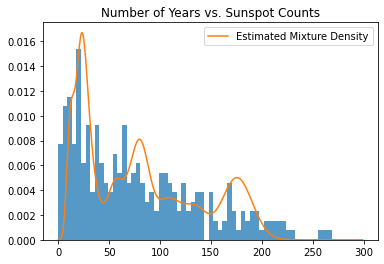

In [24]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("lambda_plate", T):
        lmbda = pyro.sample("lambda", Gamma(3, 0.05))
    
    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", Poisson(lmbda[z]), obs=data)

def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau_0 = pyro.param('tau_0', lambda: Uniform(0, 5).sample([T]), constraint=constraints.positive)
    tau_1 = pyro.param('tau_1', lambda: LogNormal(-1, 1).sample([T]), constraint=constraints.positive)
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("lambda_plate", T):
        q_lambda = pyro.sample("lambda", Gamma(tau_0, tau_1))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

T = 20
alpha = 1.1
n_iter = 1500
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

train(n_iter)

samples = torch.arange(0, 300).type(torch.float)

tau0_optimal = pyro.param("tau_0").detach()
tau1_optimal = pyro.param("tau_1").detach()
kappa_optimal = pyro.param("kappa").detach()

# We make a point-estimate of our latent variables using the posterior means of tau and kappa for the cluster params and weights
Bayes_Rates = (tau0_optimal / tau1_optimal)
Bayes_Weights = mix_weights(1. / (1. + kappa_optimal))

def mixture_of_poisson(weights, rates, samples):
    print(Poisson(rates).log_prob(samples.unsqueeze(-1)).exp())
    return (weights * Poisson(rates).log_prob(samples.unsqueeze(-1)).exp()).sum(-1)

likelihood = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)

plt.title("Number of Years vs. Sunspot Counts")
plt.hist(data.numpy(), bins=60, density=True, lw=0, alpha=0.75);
plt.plot(samples, likelihood, label="Estimated Mixture Density")
plt.legend()
plt.show()

(array([3., 1., 2., 2., 6., 2., 1., 1., 1., 1.]),
 array([0.02980027, 0.03453253, 0.03926478, 0.04399704, 0.0487293 ,
        0.05346155, 0.05819381, 0.06292606, 0.06765832, 0.07239057,
        0.07712283], dtype=float32),
 <BarContainer object of 10 artists>)

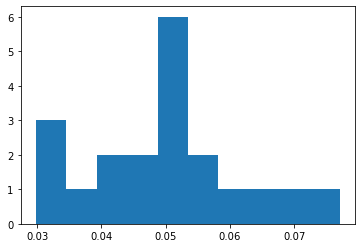

In [16]:
plt.hist(np.array(Bayes_Weights))

### ELBO Behavior

Below are plots of the behavior of the loss function (negative Trace_ELBO) over the SVI iterations during inference using Pyro, as well as a plot of the autocorrelations of the ELBO 'time series' versus iteration number. We can see that around 500 iterations, the loss stops decreasing significantly, so we can assume it takes around 500 iterations to achieve convergence. The autocorrelation plot reaches an autocorrelation very close to 0 around a lag of 500, further corroborating this hypothesis. Note that these are heuristics and do not necessarily imply convergence.

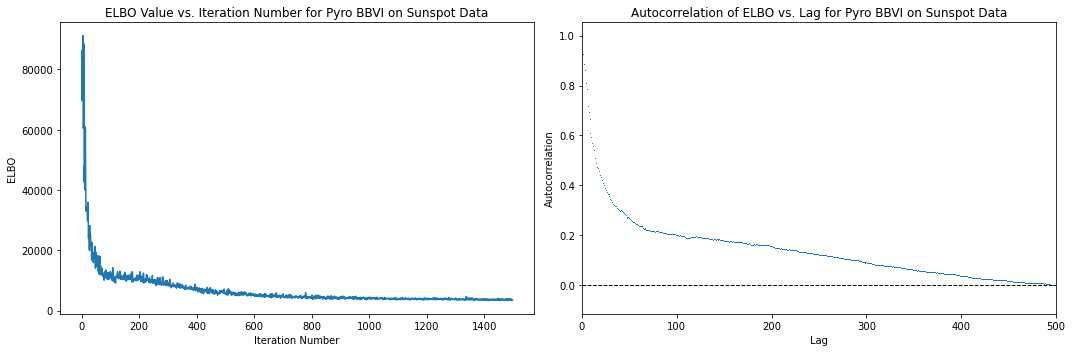

In [10]:
elbo_plot = plt.figure(figsize=(15, 5))

elbo_ax = elbo_plot.add_subplot(1, 2, 1)
elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI on Sunspot Data")
elbo_ax.set_ylabel("ELBO")
elbo_ax.set_xlabel("Iteration Number")
elbo_ax.plot(np.arange(n_iter), losses)

autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
autocorr_ax.acorr(np.asarray(losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=',')
autocorr_ax.set_xlim(0, 500)
autocorr_ax.axhline(0, ls="--", c="k", lw=1)
autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI on Sunspot Data")
autocorr_ax.set_xlabel("Lag")
autocorr_ax.set_ylabel("Autocorrelation")
elbo_plot.tight_layout()
plt.show()


100%|██████████| 500/500 [00:01<00:00, 359.49it/s]


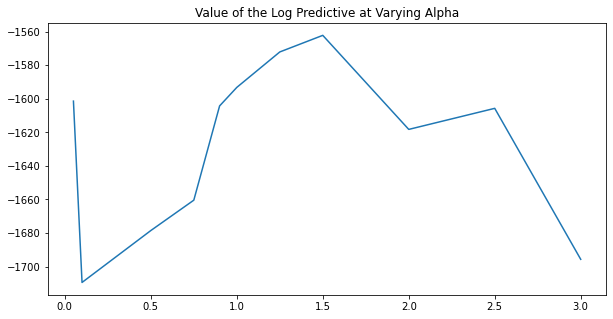

In [30]:
# Hold out 10% of our original data to test upon
df_test = df.sample(frac=0.1)
data = torch.tensor(df.drop(df_test.index)['sunspot.year'].values, dtype=torch.float).round()
data_test = torch.tensor(df_test['sunspot.year'].values, dtype=torch.float).round()
N = data.shape[0]
N_test = data_test.shape[0]

alphas = [0.05, 0.1, 0.5, 0.75, 0.9, 1., 1.25, 1.5, 2, 2.5, 3]
log_predictives = []

for val in alphas:
    alpha = val
    T = 20
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    train(500)
    
    S = 100 # number of Monte Carlo samples to use in posterior predictive computations

    # Using pyro's built in posterior predictive class:
    posterior = Predictive(guide, num_samples=S, return_sites=["beta", "lambda"])(data)
    post_pred_weights = mix_weights(posterior["beta"])
    post_pred_clusters = posterior["lambda"]

    # log_prob shape = N_test x S
    log_prob = (post_pred_weights.log() + Poisson(post_pred_clusters).log_prob(data.reshape(-1, 1, 1))).logsumexp(-1)
    mean_log_prob = log_prob.logsumexp(-1) - np.log(S)
    log_posterior_predictive = mean_log_prob.sum(-1)
    log_predictives.append(log_posterior_predictive)

plt.figure(figsize=(10, 5))
plt.plot(alphas, log_predictives)
plt.title("Value of the Log Predictive at Varying Alpha")
plt.show()

From the above plot, we would surmise that we want to set $\alpha > 1$, though the signal is not quite clear. A more comprehensive model criticism process would involve performing a grid search across all hyperparameters in order to find the one that maximizes the log predictive.


## References



1.   Ferguson, Thomas. *A Bayesian Analysis of Some Nonparametric Problems*. The Annals of Statistics, Vol. 1, No. 2 (1973). 
2.   Aldous, D. *Exchangeability and Related Topics*. Ecole diete de Probabilities Saint Flour (1985).
3.   Sethuraman, J. *A Constructive Definition of Dirichlet Priors*. Statistica, Sinica, 4:639-650 (1994).
4.   Blei, David and Jordan, Michael. *Variational Inference for Dirichlet Process Mixtures*. Bayesian Analysis, Vol. 1, No. 1 (2004).
5.   Pedregosa, et al. *Scikit-Learn: Machine Learning in Python*. JMLR 12, pp. 2825-2830 (2011).
6.   Bishop, Christopher. *Pattern Recogition and Machine Learning*. Springer Ltd (2006).
7.   *Sunspot Index and Long-Term Solar Observations*. WDC-SILSO, Royal Observatory of Belgium, Brussels (2018).
9.   Gelman, Andrew. *Understanding predictive information criteria for Bayesian models*. Statistics and Computing, Springer Link, 2014.



